In [1]:
from __future__ import print_function, division
import sys
sys.path.insert(0, 'lib')
import numpy as np
import random
import pydicom
import os
import matplotlib.pyplot as plt
import pickle
import math
import pydicom
from shutil import copyfile
import nibabel as nib
import scipy.ndimage as ndimage
from scipy.stats import pearsonr, spearmanr

from utils import make_giant_mat, make_dictionary, make_echo_dict
from difference_map_utils import make_difference
from cluster_utils import threshold_diffmaps, strip_empty_lines, resize
from lesion_utils import *
from inference_utils import run_inference
from make_inference_csv import *
from compare_segmentations import get_dice_scores, get_jaccard_indices, compare_segmentation_masks, compare_region_means, compare_region_changes
from loss_functions import coefficient_of_variation
from figure_utils import plot_mean_val_comparisons


Using TensorFlow backend.


In [2]:
import zipfile
from calculate_t2 import fit_t2
from segmentation_refinement import *
from projection import *
from inference_utils import *
import time
import shutil
from skimage.transform import resize

In [3]:
# Define a few functions that will help us find the dicom files and filter out anything else in the ./input subdirectory
def get_slices(scan_dir):
    '''
    scan_dir = path to folder containing dicoms such that each dicom represents one slice of the image volume
    '''
    list_of_slices = glob.glob("{}/**".format(scan_dir),
                               recursive=True)
    return list(filter(is_dicom, list_of_slices))

def is_dicom(fullpath):
    if os.path.isdir(fullpath):
        return False
    _, path = os.path.split(fullpath)
    
    path = path.lower()
    if path[-4:] == ".dcm":
        return True
    if not "." in path:
        return True
    return False


In [4]:
# Specify the folder where you put your images. 
# NOTE 1: Each MRI volume should be a separate zip folder of dicom files. 
# NOTE 2: All dicom files should be sagittal T2-map knee MRI files. This code does not filter out other dicom files. 
input_dir = './input'

# Specify the folder where we should save the results of the analysis
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)

# Look for the zip files in the ./input subdirectory
vol_zip_list = np.sort([os.path.join(input_dir,i) for i in os.listdir(input_dir) if i[-4:]=='.zip'])

# Get the trained model ready
model_weight_file = './model_weights/model_weights_quartileNormalization_echoAug.h5'
model = get_model(model_weight_file)

# Prepare the CSV where we will write a summary of all the results
region_list = ['all', 'superficial', 'deep','L', 'M', 'LA', 'LC', 'LP', 'MA', 'MC', 'MP', 'SL', 'DL', 'SM', 'DM','SLA', 'SLC', 'SLP', 'SMA', 'SMC', 'SMP', 'DLA', 'DLC', 'DLP', 'DMA', 'DMC', 'DMP']
output_file = open(os.path.join(output_dir,'predictions.csv'), 'w')
output_file.write('filename,'+','.join(region_list)+'\n')

total_time = 0
for zip_num, vol_zip in enumerate(vol_zip_list):
    print("Processing file %s..." % os.path.basename(vol_zip))
    
    # Track how much time it takes to analyze each image
    time1 = time.time()
    
    # Make an ./output subdirectory where we will save all results
    new_dir_name = os.path.join('./output', os.path.splitext(os.path.basename(vol_zip))[0])
    os.makedirs(new_dir_name, exist_ok=True)
    
    # Make a directory where we will save the dicom files extracted from the zipped folder
    dicom_sub_dir = os.path.join(new_dir_name,"dicom")
    raw_extract_dir = os.path.join(new_dir_name,"raw_extract")
    os.makedirs(dicom_sub_dir, exist_ok=True)
    
    # Unzip the image volume. If the zip file contains an inner directory, move the files out of it. 
    with zipfile.ZipFile(vol_zip, 'r') as zip_ref:
        zip_ref.extractall(raw_extract_dir)
    
    slice_path_list = get_slices(raw_extract_dir)
    for s in slice_path_list:
        shutil.copy(s,os.path.join(dicom_sub_dir, os.path.basename(s)))
    shutil.rmtree(raw_extract_dir)
    
    # Make a 4D Multi-echo spin echo (MESE) array of dimensions (slice, echo times, rows, columns), 
    # and get the echo times for each slice
    mese, times = assemble_4d_mese_v2(dicom_sub_dir)
    
    # If the slices are not 384x384, resize them (the model was trained on 384x384 images from OAI)
    mese_resized = np.zeros((mese.shape[0], mese.shape[1], 384,384))
    for s in range(mese.shape[0]):
        for echo in range(mese.shape[1]):
            mese_resized[s,echo,:,:] = resize(mese[s,echo,:,:], (384, 384),anti_aliasing=True)
    mese = mese_resized
    
    
    # Whiten (i.e. normalize) the echo time of each slice that is closest to 20ms 
    mese_white = []
    for i,s in enumerate(mese):
        if times[i][0] is not None:
            slice_times = times[i]
        else:
            times[i][0]=times[i][1]-(times[i][2]-times[i][1])
            slice_times = times[i]
        slice_20ms_idx = np.argmin(slice_times-.02)
        mese_white.append(whiten_img(s[slice_20ms_idx,:,:], normalization = 'quartile'))
    mese_white = np.stack(mese_white).squeeze()
    
    # Estimate segmentation
    seg_pred = model.predict(mese_white.reshape(-1,384,384,1), batch_size = 6)
    seg_pred = seg_pred.squeeze()
    
    # Calculate T2 Map
    t2 = fit_t2(mese, times, segmentation = seg_pred, n_jobs = 4, show_bad_pixels = False)
    
    # Refine the comparison segmentation by throwing out non-physiologic T2 values
    seg_pred, t2 = t2_threshold(seg_pred, t2, t2_low=0, t2_high=100)
    seg_pred, t2 = optimal_binarize(seg_pred, t2, prob_threshold=0.501, voxel_count_threshold=425)
    
    # Project the 3D T2 map onto a 2D surface using polar coordinates
    angular_bin = 5
    visualization, thickness_map, min_rho_map, max_rho_map, avg_vals_dict, R = projection(t2, 
                                                                                       thickness_div = 0.5, 
                                                                                       values_threshold = 100,
                                                                                       angular_bin = angular_bin, 
                                                                                       region_stat = 'mean',
                                                                                       fig = False)

    # Measure the physical width and length of the 2D projection
    row_distance, column_distance = get_physical_dimensions(img_dir = dicom_sub_dir, 
                                                            t2_projection = visualization, 
                                                            projection_pixel_radius = R, 
                                                            angular_bin = angular_bin)

    # Save the t2 image, segmentation, and projection results
    
    ## Save the 3D binary segmentation mask as a numpy array
    refined_seg_path = os.path.join(new_dir_name,"segmentation_mask.npy")
    np.save(refined_seg_path, seg_pred)
    
    ## Save the 3D binary segmentation mask as a folder of CSV files
    seg_sub_dir = os.path.join(new_dir_name,"segmentation_mask_csv")
    os.makedirs(seg_sub_dir, exist_ok=True)
    
    for i,s in enumerate(seg_pred):
        slice_path = os.path.join(seg_sub_dir,str(i).zfill(3)+".csv")
        np.savetxt(slice_path, s,delimiter=",", fmt='%10.5f')
                
    ## Save the 3D T2 image as a numpy array
    t2_img_path = os.path.join(new_dir_name,"t2.npy")
    np.save(t2_img_path, t2)
    
    ## Save the 3D T2 image as a folder of CSV files
    t2_sub_dir = os.path.join(new_dir_name,"t2_csv")
    os.makedirs(t2_sub_dir, exist_ok=True)
    
    for i,s in enumerate(t2):
        slice_path = os.path.join(t2_sub_dir,str(i).zfill(3)+".csv")
        np.savetxt(slice_path, s,delimiter=",", fmt='%10.5f')
    
    ## Save the 2D projection of the T2 map as a numpy array
    t2_projection_path = os.path.join(new_dir_name,"t2_projection.npy")
    np.save(t2_projection_path, visualization)
    
    ## Save the 2D projection of the T2 map as a csv
    t2_projection_csv_path = os.path.join(new_dir_name,"t2_projection.csv")
    np.savetxt(t2_projection_csv_path, visualization,delimiter=",", fmt='%10.5f')
    
    ## Save the 2D projection thickness map as a numpy array
    thickness_projection_path = os.path.join(new_dir_name,"thickness_projection.npy")
    np.save(thickness_projection_path, thickness_map)
    
    ## Save the 2D projection thickness map as a csv
    thickness_projection_csv_path = os.path.join(new_dir_name,"thickness_projection.csv")
    np.savetxt(thickness_projection_csv_path, thickness_map,delimiter=",", fmt='%10.5f')
    
    ## Save the physical dimensions of the 2D projections as a json
    projection_dimensions_dict = {}
    projection_dimensions_dict['row_distance(mm)'] = row_distance
    projection_dimensions_dict['column_distance(mm)'] = column_distance
    projection_dimensions_dict_path = os.path.join(new_dir_name,"projection_dimensions.json")
    with open(projection_dimensions_dict_path, 'w') as fp:
        json.dump(projection_dimensions_dict, fp)
        
    ## Save the region average T2 dictionary as a json
    t2_region_json_path = os.path.join(new_dir_name,"region_mean_t2.json")
    with open(t2_region_json_path, 'w') as fp:
        json.dump(avg_vals_dict, fp)
    
    # Track how much time it takes to analyze each image
    time2 = time.time()
    total_time = total_time + (time2-time1)
    avg_pace = total_time / (zip_num+1)
    files_remaining = len(vol_zip_list) - zip_num
    print("Estimated time remaining for all files(min):",np.round(files_remaining*avg_pace/60,decimals=1))    
    
    # Record the average regional T2 values for this image to a summary CSV file where we're recording these metrics for all input images
    output_file.write('%s,' % os.path.basename(vol_zip))
    for r in region_list:
        if r == 'DMP':
            output_file.write('%d' % avg_vals_dict[r])
        else:
            output_file.write('%d,' % avg_vals_dict[r])

    output_file.write('\n')    

output_file.close()
print("Analysis Complete")
    

/home/ubuntu/AutomaticKneeMRISegmentation/models.py:97: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(512, (3, 3), padding="same", strides=(2, 2))`
  output_shape=deconv_shape)(conv),
/home/ubuntu/AutomaticKneeMRISegmentation/models.py:97: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(256, (3, 3), padding="same", strides=(2, 2))`
  output_shape=deconv_shape)(conv),
/home/ubuntu/AutomaticKneeMRISegmentation/models.py:97: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(128, (3, 3), padding="same", strides=(2, 2))`
  output_shape=deconv_shape)(conv),
/home/ubuntu/AutomaticKneeMRISegmentation/models.py:97: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(64, (3, 3), padding="same", strides=(2, 2))`
  output_shape=deconv_shape)(conv),
/home/ubuntu/AutomaticKneeMRISegmentation/models.py:97: UserWarning: Update your `Conv2DTranspose` call to th

Processing file 9000099_00m.zip...


/home/ubuntu/kneeseg/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/ubuntu/kneeseg/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/kneeseg/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Estimated time remaining for all files(min): 4.6
Processing file 9000099_12m.zip...
Estimated time remaining for all files(min): 4.0
Processing file 9000099_24m.zip...
Estimated time remaining for all files(min): 3.4
Processing file 9000099_30m.zip...
Estimated time remaining for all files(min): 2.8
Processing file 9000099_36m.zip...
Estimated time remaining for all files(min): 2.3
Processing file 9000099_48m.zip...
Estimated time remaining for all files(min): 1.7
Processing file 9000099_72m.zip...
Estimated time remaining for all files(min): 1.1
Processing file 9000099_96m.zip...
Estimated time remaining for all files(min): 0.5
Analysis Complete


In [5]:
# Check out the ./output subdirectory where we've saved all results
os.listdir('./output')

['9000099_48m',
 '9000099_72m',
 'predictions.csv',
 '9000099_30m',
 '9000099_36m',
 '9000099_24m',
 '9000099_00m',
 '9000099_12m',
 '9000099_96m']

In [6]:
# Look at the subregional mean T2 value for each subregion of all images
results_summary_path = os.path.join(output_dir, 'predictions.csv')
print("File located at:", results_summary_path)
pd.read_csv(results_summary_path)

File located at: ./output/predictions.csv


,filename,all,superficial,deep,L,M,LA,LC,LP,MA,...,SLP,SMA,SMC,SMP,DLA,DLC,DLP,DMA,DMC,DMP
0,9000099_00m.zip,58,60,56,56,60,60,52,56,59,...,58,62,62,63,60,50,54,56,59,60
1,9000099_12m.zip,59,60,57,57,61,61,52,57,59,...,59,61,63,64,60,51,55,56,60,63
2,9000099_24m.zip,57,59,55,55,60,60,51,56,60,...,59,62,64,61,59,49,53,58,59,56
3,9000099_30m.zip,57,59,56,55,60,60,51,54,62,...,56,63,60,61,60,50,53,60,58,58
4,9000099_36m.zip,58,60,57,56,61,62,52,56,61,...,58,64,62,64,61,51,54,58,59,59
5,9000099_48m.zip,58,60,56,56,61,63,52,55,61,...,58,63,64,63,63,50,52,60,59,60
6,9000099_72m.zip,59,62,55,56,61,64,47,58,65,...,64,67,62,62,64,42,53,63,56,56
7,9000099_96m.zip,56,59,52,53,58,58,44,55,62,...,58,66,57,61,58,41,53,59,50,52


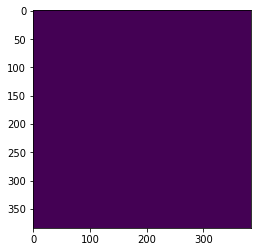

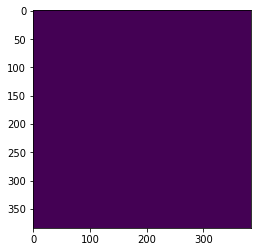

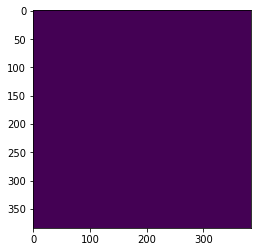

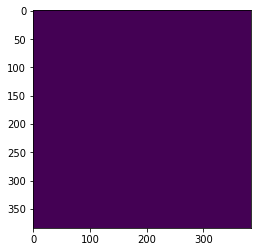

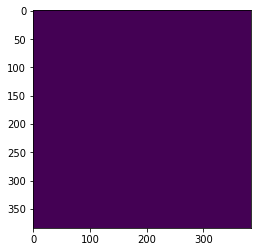

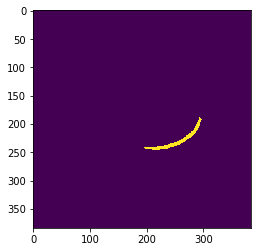

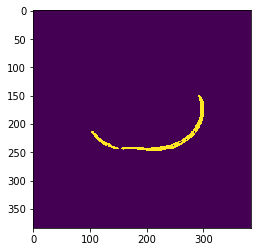

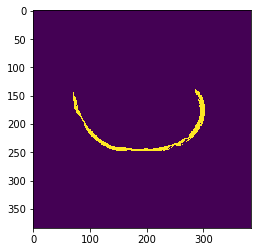

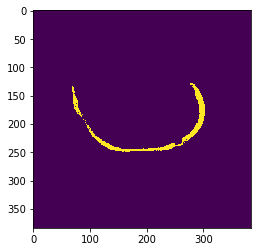

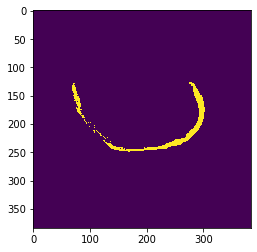

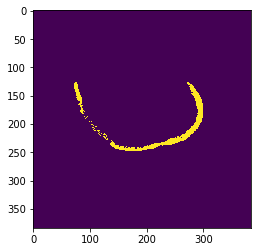

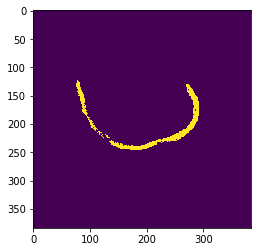

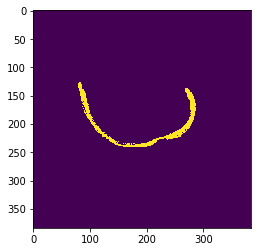

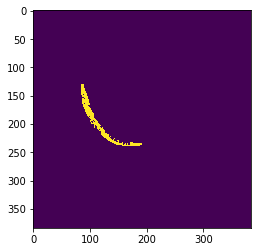

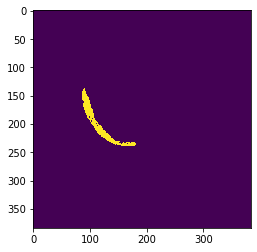

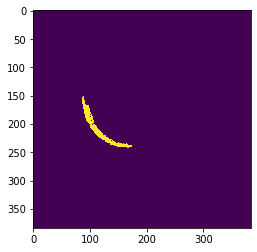

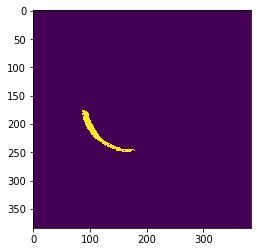

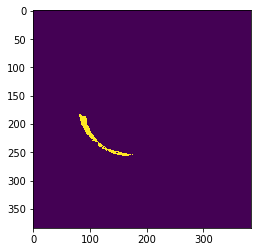

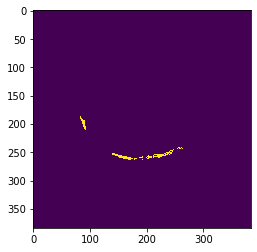

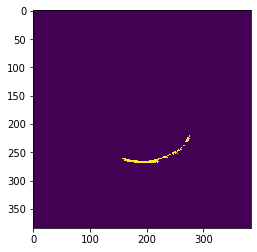

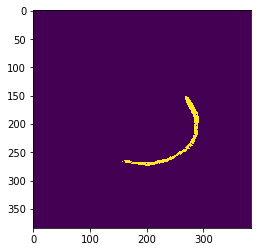

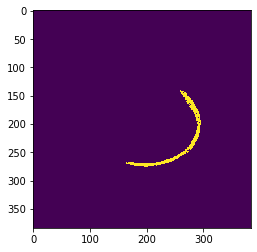

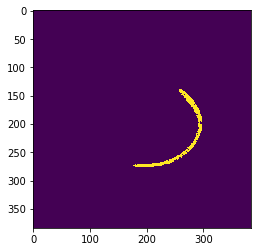

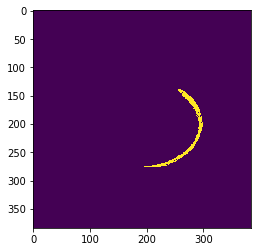

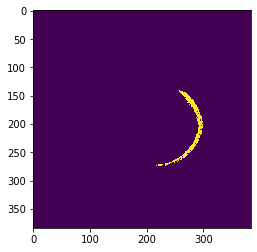

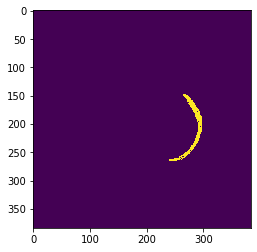

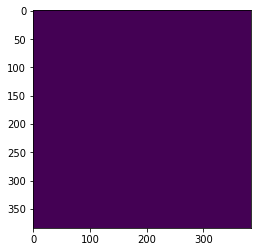

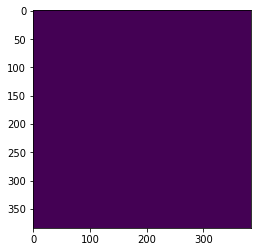

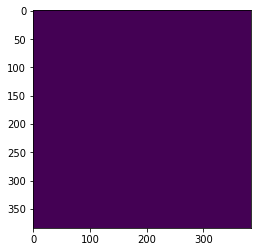

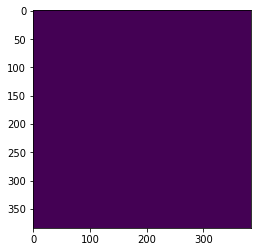

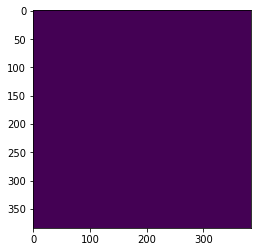

In [7]:
# Look at the segmentation mask for one image:
output_subdir_list = [i for i in glob.glob(output_dir + '/*') if i[-4:]!='.csv']
segmentation_path = os.path.join(output_subdir_list[0],'segmentation_mask.npy')
segmentation_mask = np.load(segmentation_path)
for s in segmentation_mask:
    plt.imshow(s)
    plt.show()

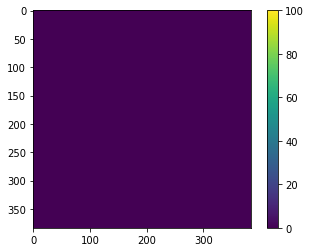

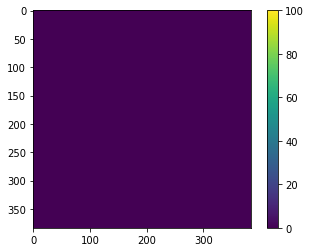

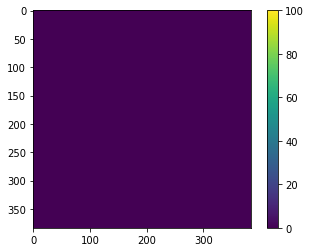

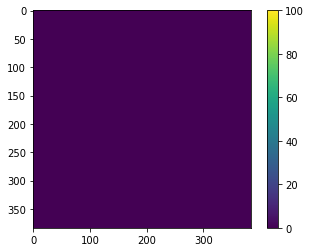

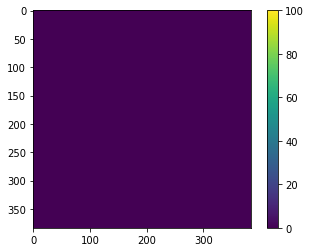

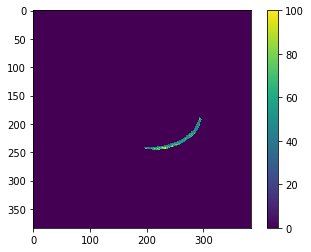

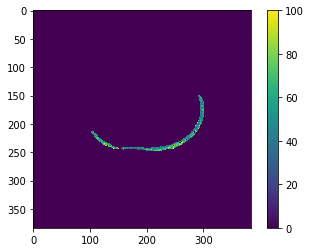

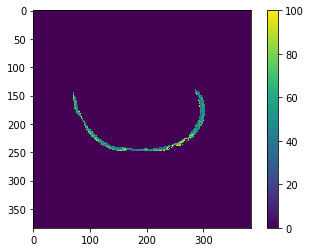

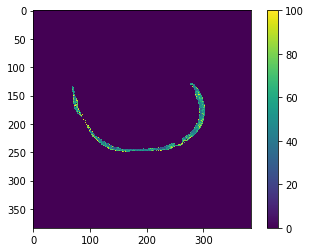

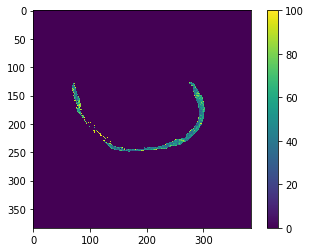

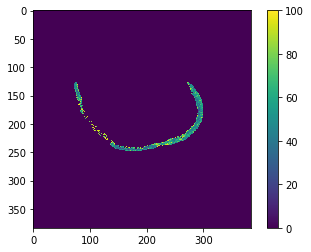

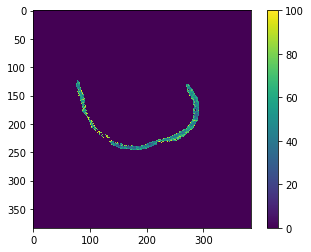

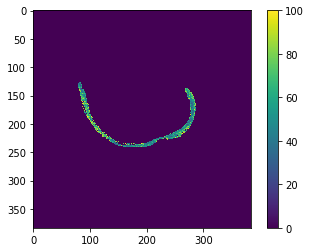

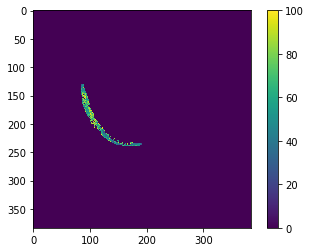

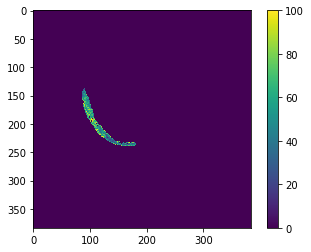

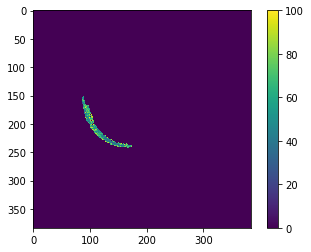

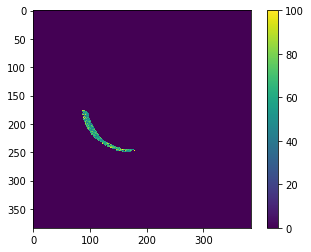

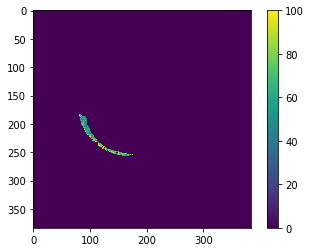

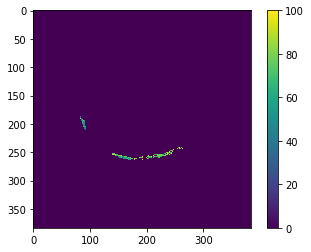

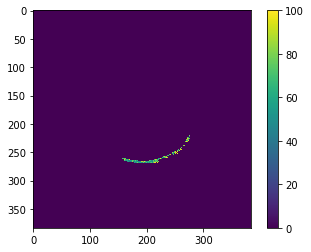

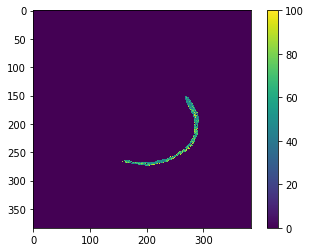

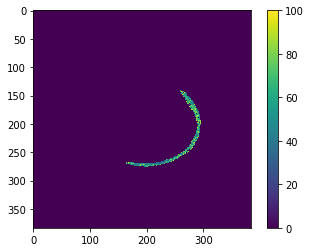

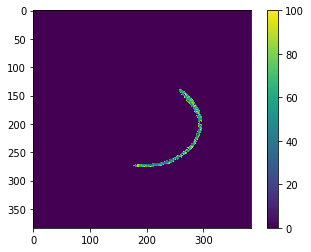

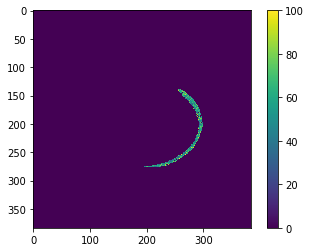

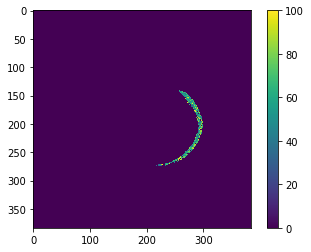

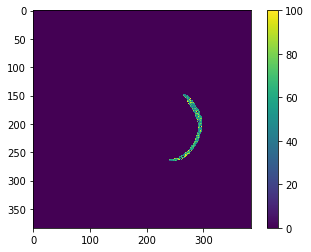

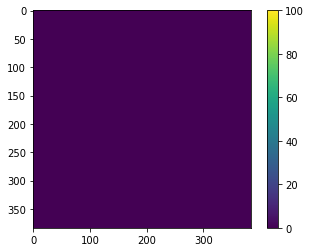

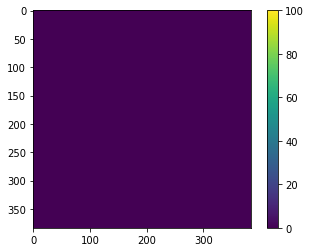

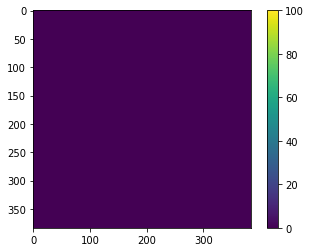

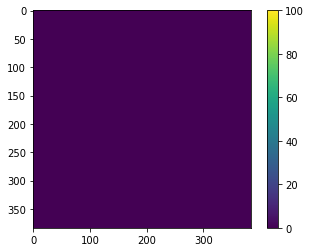

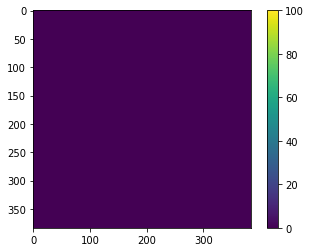

In [8]:
# Look at the 3D T2 map
t2_path = os.path.join(output_subdir_list[0],'t2.npy')
t2 = np.load(t2_path)
for s in t2:
    plt.imshow(s)
    plt.clim([0,100])
    plt.colorbar()
    plt.show()

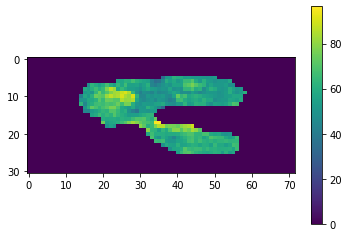

In [9]:
# Look at the 2D projection of the T2 map
t2_projection_path = os.path.join(output_subdir_list[0],'t2_projection.npy')
t2_projection = np.load(t2_projection_path)
plt.imshow(t2_projection)
plt.colorbar()
plt.show()

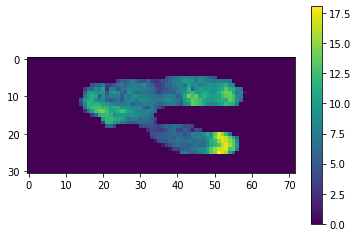

In [10]:
# Look at the 2D thickness map of the T2 map
thickness_projection_path = os.path.join(output_subdir_list[0],'thickness_projection.npy')
thickness_projection = np.load(thickness_projection_path)
plt.imshow(thickness_projection)
plt.colorbar()
plt.show()